In [1]:
import torch
import torchvision
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.cuda.amp import autocast,GradScaler

In [2]:
import cv2
import os
import PIL
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import onnxruntime
from tqdm import tqdm
from pprint import pprint
from typing import Tuple,List,Dict
from xml.etree import cElementTree as etree
from scipy.integrate import trapezoid

In [3]:
class conv3x3(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride=1):
        super(conv3x3,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,(3,3),stride=stride,padding=1)
#         self.bn = nn.BatchNorm2d(out_channels)
        nn.init.trunc_normal_(self.conv.weight,mean=0.0,std=0.01)
        
    def forward(self,x):
        tmp = self.conv(x)
#         tmp = self.bn(tmp)
        tmp = F.leaky_relu(tmp,0.1,inplace=True)
        return tmp

In [4]:
class conv1x1(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride=1):
        super(conv1x1,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,(1,1),stride=stride)
#         self.bn = nn.BatchNorm2d(out_channels)
        nn.init.trunc_normal_(self.conv.weight,mean=0.0,std=0.01)
        
    def forward(self,x):
        tmp = self.conv(x)
#         tmp = self.bn(tmp)
        tmp = F.leaky_relu(tmp,0.1,inplace=True)
        return tmp

In [5]:
class yolov1(nn.Module):
    
    def __init__(self):
        super(yolov1,self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3,64,(7,7),stride=2,padding=3),
#             nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2),stride=2)
        )
        self.conv_2 = nn.Sequential(
            conv3x3(64,192),
            nn.MaxPool2d((2,2),stride=2)
        )
        self.conv_3 = nn.Sequential(
            conv1x1(192,128),
            conv3x3(128,256),
            conv1x1(256,256),
            conv3x3(256,512),
            nn.MaxPool2d((2,2),stride=2)            
        )
        self.conv_4 = nn.Sequential(
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,512),
            conv3x3(512,1024),
            nn.MaxPool2d((2,2),stride=2)            
        )
        self.conv_5 = nn.Sequential(
            conv1x1(1024,512),
            conv3x3(512,1024),
            conv1x1(1024,512),
            conv3x3(512,1024), # end of backbone
            conv3x3(1024,1024),
            conv3x3(1024,1024,stride=2)
        )
        self.conv_6 = nn.Sequential(
            conv3x3(1024,1024),
            conv3x3(1024,1024)
        )
        
#         self.classifier = nn.Sequential(
# #             nn.Linear(7*7*1024,4096),
# #             nn.Dropout(p=.5),
# #             nn.LeakyReLU(0.1),
#             nn.Linear(7*7*1024,7*7*30),
#         )
        self.conv_out = nn.Sequential(
#             conv3x3(1024,1024),
#             nn.Dropout(p=.5),
            nn.Conv2d(1024,30,(1,1),stride=1)
        )

        
    def forward(self,x):
        tmp = self.conv_1(x) # 112 x 112 x 64 # conv stride 2 will reduce hw 2 times too
        tmp = self.conv_2(tmp) # 56 X 56 X 192
        tmp = self.conv_3(tmp) # 28 x 28 x 512
        tmp = self.conv_4(tmp) # 14 x 14 x 1024
        tmp = self.conv_5(tmp) # 7 x 7 x 1024 # conv stride 2 will reduce hw 2 times too
        tmp = self.conv_6(tmp) # 7 x 7 x 1024
        
        tmp = self.conv_out(tmp)
        
#         tmp = torch.flatten(tmp,start_dim=1)
#         tmp = self.classifier(tmp)
#         tmp = tmp.reshape(-1,30,7,7)#.contiguous()
        
        return tmp

In [6]:
class yolov1_resnet18(nn.Module):
    
    def __init__(self):
        super(yolov1_resnet18,self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=True)
        
        # as paper suggested, deeper conv layer
        self.conv = nn.Sequential(
            nn.Conv2d(512,512,3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,1,stride=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
#         self.classifier = nn.Sequential(
# #             nn.Linear(7*7*512,4096),
# #             nn.Dropout(p=.5),
# #             nn.LeakyReLU(0.1),
#             nn.Linear(4096,7*7*30),
#         )

        self.conv_out = nn.Sequential(
            nn.Conv2d(512,30,(1,1),stride=1)
        )

        
    def forward(self,x):
        tmp = self.backbone.conv1(x)
        tmp = self.backbone.bn1(tmp)
        tmp = self.backbone.relu(tmp)
        tmp = self.backbone.maxpool(tmp)
        tmp = self.backbone.layer1(tmp)
        tmp = self.backbone.layer2(tmp)
        tmp = self.backbone.layer3(tmp)
        tmp = self.backbone.layer4(tmp)
        
        tmp = self.conv(tmp)
        tmp = self.conv_out(tmp)
        
#         tmp = torch.flatten(tmp,start_dim=1)
#         tmp = self.classifier(tmp)
#         tmp = tmp.reshape(-1,30,7,7)#.contiguous()
        
        return tmp

In [7]:
#模型測試
torch.testing.assert_equal(yolov1()(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))

C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
#模型測試
torch.testing.assert_equal(yolov1_resnet18()(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))

In [9]:
def generate_grid_train(grid_size: Tuple[int, int]) -> torch.Tensor:
    # recover x,y coord since we use x,y offset
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))    
    
    grid_tmp = torch.cat([x_offset.unsqueeze(0),y_offset.unsqueeze(0)],dim=0) # 2, 7, 7

    grid_tmp = grid_tmp.unsqueeze(0)/grid_size[0] # 1, 2, 7 ,7 # to relative
    
    return grid_tmp

In [10]:
def xywh_to_xyxy(coord: torch.Tensor) -> torch.Tensor:
    # convert xywh to xyxy
    b, _, sx, sy = coord.shape
    d = 'cuda:0' if coord.is_cuda else 'cpu'
    grid_for_train = generate_grid_train((sx,sy)).repeat(b,1,1,1).to(d) 
    xy = coord[:,0:2,:,:]+grid_for_train # B, 2, 7, 7
    wh = coord[:,2:4,:,:] # B, 2, 7, 7 

    return torch.cat([xy-wh/2,xy+wh/2],dim=1) # B, 4, 7, 7

In [11]:
def IOU(cbox1: torch.Tensor, cbox2: torch.Tensor) -> torch.Tensor:
    """
    input: x_offset y_offset wh format
    output: iou for each batch and grid cell
    """
    
    # prevent zero division since most of grid cell are zero area
    epsilon = 1e-10
    
    # coord_conversion
    box1 = xywh_to_xyxy(cbox1) # B, 4, 7, 7
    box2 = xywh_to_xyxy(cbox2)
    
    # find intersection
    x1 = torch.max(box1[:,0:1,:,:],box2[:,0:1,:,:])
    y1 = torch.max(box1[:,1:2,:,:],box2[:,1:2,:,:])
    x2 = torch.min(box1[:,2:3,:,:],box2[:,2:3,:,:])
    y2 = torch.min(box1[:,3:4,:,:],box2[:,3:4,:,:])
    
    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0) # N, 1, 7, 7
    
    total_area = (cbox1[:,2:3,:,:]*cbox1[:,3:4,:,:]).abs() + cbox2[:,2:3,:,:]*cbox2[:,3:4,:,:] - intersection # N, 1, 7, 7
    
    assert intersection.ge(0).all(), 'intersection should be more than 0'
    assert total_area.ge(0).all(), 'total area should be more than 0'
    
    # compute iou
    value = intersection/(total_area+epsilon)
    
    return value

In [12]:
class YoloLoss(nn.Module):
    
    def __init__(self, lambda_coord = 5, lambda_noobject = 0.5):
        super(YoloLoss,self).__init__()
        
        self.grid_size = IMAGE_SIZE/64
        self.num_bbox = NUM_BOXES
        self.lambda_coord = lambda_coord
        self.lambda_noobject = lambda_noobject
        self.epsilon = 1e-5
        
    def iou_box(self, prediction: torch.Tensor, groundtruth: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        ious = [IOU(prediction[:,(1+5*b):(5+5*b),:,:],groundtruth[:,1:5,:,:]) for b in range(self.num_bbox)]
        ious = torch.cat(ious,dim=1) # N, boxes, 7, 7
        max_iou, best_box = ious.max(dim=1,keepdim=True) # N,1,7,7
        return max_iou, best_box
        
    def forward(self, prediction: torch.Tensor, groundtruth: torch.Tensor) -> torch.Tensor:
        groundtruth = groundtruth.float()
        
        # obj indicator
        obj_here = groundtruth[:,0:1,:,:] # [N,1,7,7]
        
        # iou indicator
        ious, best_box = self.iou_box(prediction, groundtruth) # N, 1, 7, 7
                  
        # left only 49 predictors
        box_pred = torch.zeros_like(prediction[:,:5,:,:]) # N, 5, 7, 7
        for b in range(self.num_bbox): box_pred += best_box.eq(b) * prediction[:,b*5:(b+1)*5,:,:]
        cls_pred = prediction[:,self.num_bbox*5:,:,:]
        wh_pred = box_pred[:,3:5,:,:].sign() * (box_pred[:,3:5,:,:].abs()+self.epsilon).sqrt() # sqrt the value then plus sign back
        
        # class loss objecness loss and xywh loss                
        # indicator has to be inside the loss function
        cls_loss = F.mse_loss(obj_here*cls_pred, groundtruth[:,5:,:,:],reduction="sum")
        obj_loss = F.mse_loss(obj_here*box_pred[:,0:1,:,:], obj_here,reduction="sum")
        xy_loss = F.mse_loss(obj_here*box_pred[:,1:3,:,:], groundtruth[:,1:3,:,:],reduction="sum")
        wh_loss = F.mse_loss(obj_here*wh_pred, groundtruth[:,3:5,:,:].sqrt(),reduction="sum")
        
        # not mention in the original papaer, but in aladdin and clean the other bbox block with wrong confidence
        noobj_loss = 0.0
        for b in range(self.num_bbox):
            noobj_loss += F.mse_loss((1-obj_here)*prediction[:,0+5*b:1+5*b,:,:], obj_here*0,reduction="sum") # weird part 
        
        total_loss = cls_loss + self.lambda_noobject * noobj_loss + obj_loss + self.lambda_coord * (xy_loss + wh_loss)

        return total_loss

In [13]:
class VOC_dataset(torch.utils.data.Dataset):
    
    def __init__(self, root, year='2012', transform=None, grid_size=7, num_classes=20):
        label_path = os.path.join(root,f'VOCdevkit/VOC{year}/Annotations/')

        self.root = root
        self.year = year
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.transform = transform
        self.labels = os.listdir(label_path)
        
    def __len__(self):
        return len(self.labels)
        # return 1000
    
    def __getitem__(self, idx):
        stride = IMAGE_SIZE/self.grid_size
        
        xml = os.path.join(self.root,f'VOCdevkit/VOC{self.year}/Annotations/',self.labels[idx])
        jpg = os.path.join(self.root,f'VOCdevkit/VOC{self.year}/JPEGImages/',self.labels[idx].replace('xml','jpg'))
        
        img = PIL.Image.open(jpg)
        label = np.zeros((5+self.num_classes,self.grid_size,self.grid_size))
        tree = etree.parse(xml)
        tree = tree.findall('object')
        
        for obj in tree:
            bbox = obj.find('bndbox')
            
            img_w, img_h = img.size
            xmin = int(float(bbox.find('xmin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymin = int(float(bbox.find('ymin').text))
            ymax = int(float(bbox.find('ymax').text))

            w = (xmax-xmin)/img_w
            h = (ymax-ymin)/img_h

            class_ind = voc_classes.index(obj.find('name').text)
            
            cx = (xmin+xmax)/2/img_w
            cy = (ymin+ymax)/2/img_h
            x = (cx % (1/self.grid_size)) # left offset
            y = (cy % (1/self.grid_size)) # top offset
            
            x_ind = int(cx*self.grid_size)
            y_ind = int(cy*self.grid_size)
            label[0,y_ind,x_ind] = 1
            label[1:5,y_ind,x_ind] = [x,y,w,h]
            label[5+class_ind,y_ind,x_ind] = 1

        
        if self.transform: img = self.transform(img)
        label = torch.from_numpy(label)
        
        return img, label

# setting

In [14]:
torch.backends.cudnn.benchmark=True

In [15]:
MODEL_BACKBONE='resnet18'
BATCH_SIZE=64 if MODEL_BACKBONE == 'resnet18' else 32
IMAGE_SIZE=448
device='cuda:0'
NUM_BOXES=2

In [16]:
voc_classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", "diningtable",
            "dog", "horse", "motorbike", "person", "pottedplant",
            "sheep", "sofa", "train", "tvmonitor"]

In [17]:
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [18]:
# lift could be easier with torchvision.datasets.VOCDetection

In [19]:
trainset = VOC_dataset('../data',year='2012',transform=preprocess)
testset = VOC_dataset('../data',year='2007',transform=preprocess)

In [20]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,pin_memory=True)

In [21]:
if MODEL_BACKBONE == 'resnet18':
    model = yolov1_resnet18().to(device)
elif MODEL_BACKBONE == 'yolov1':
    model = yolov1().to(device)

In [22]:
criterion = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=5e-4)
scaler = GradScaler() # amp

# training

In [25]:
def train(e):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        optimizer.zero_grad(set_to_none=True)

        img, label = data
        
        img= img.to(device) 
        label = label.to(device) 

#         with autocast():
        output = model(img)
        loss = criterion(output,label)
        
        loss.backward()
        optimizer.step()
        
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

        running_loss += loss.item()
        
        assert not np.isnan(running_loss), 'loss died'
        
        # print loss every 100 batch
        if (i+1) % 100 == 0: 
            print(running_loss/(i+1)/BATCH_SIZE)
        
        training_loss_history.append(loss.item())
    
    if (e+1) % 10 == 0:
        torch.save(model.state_dict(),f'yolov1.resnet18.{e+1}.pth')
            
    print(f'epoch {e+1} : {running_loss/len(trainset)}')

In [ ]:
training_loss_history = []
epoches = 100
for epoch in range(10,epoches):
    train(epoch)

 16%|████████████▉                                                                    | 43/268 [00:47<03:50,  1.02s/it]

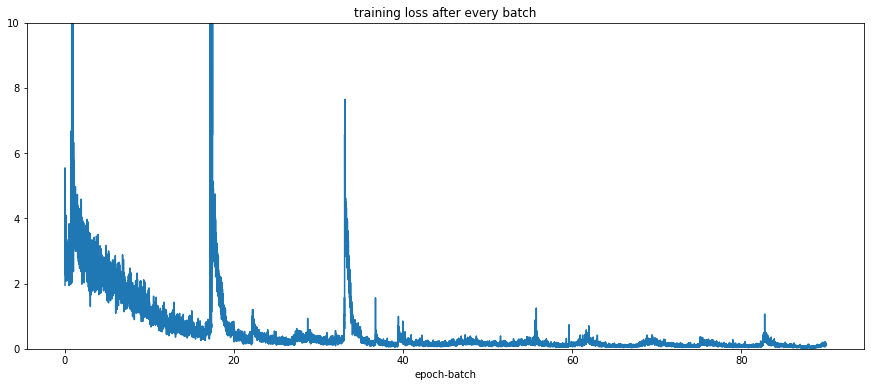

In [99]:
plt.figure(figsize=(15,6))
plt.ylim(0,10)
plt.title('training loss after every batch')
plt.xlabel('epoch-batch')
plt.plot([j+i/len(trainloader) for j in range(int(len(training_loss_history)/len(trainloader))) for i in range(len(trainloader))], np.array(training_loss_history)/BATCH_SIZE)
# plt.plot(training_loss_history)

In [168]:
# training requires day
4.5*100/1440

0.3125

# save & load

In [24]:
# test if output degenerate
a,b = trainset[0][0],trainset[100][0]
print(a.eq(b).all())
a_x, b_x = model(a.unsqueeze(0).to(device)), model(b.unsqueeze(0).to(device))
print(a_x.eq(b_x).all())

tensor(False)
tensor(False, device='cuda:0')


In [300]:
# manual save carefully, if you have many checkpoints
if MODEL_BACKBONE == 'yolov1':
    torch.save(model.state_dict(),'yolov1.pth')
elif MODEL_BACKBONE == 'resnet18':
    torch.save(model.state_dict(),'yolov1.resnet18.10.pth')    

In [24]:
# load carefully, if you have many checkpoints
if MODEL_BACKBONE == 'yolov1':
    model.load_state_dict(torch.load('yolov1.pth'))
elif MODEL_BACKBONE == 'resnet18':
    model.load_state_dict(torch.load('yolov1.resnet18.10.pth'))

# decode

In [30]:
def generate_grid(grid_size: Tuple[int]) -> torch.Tensor:
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))
    
    return x_offset, y_offset

In [31]:
def yolov1_decode(featuremap: torch.Tensor, model_image_size: Tuple[int, int], num_classes: int, num_anchors: int) -> torch.Tensor:
    
    batch_size, channel_size, fm_h, fm_w = featuremap.shape
    input_h, input_w = model_image_size
    stride_x, stride_y = input_w/fm_w, input_h/fm_h
    num_bbox = int((channel_size - num_classes)/5)
    
    grid_x, grid_y = generate_grid((fm_w,fm_h))

    bbox_info = []
    for b in range(num_bbox):
        # batch_size, 1, grid_size x grid_size
        cx = (featuremap[:,(1+5*b):(2+5*b),:,:]*input_w+grid_x*stride_x).reshape(batch_size,1,-1) 
        cy = (featuremap[:,(2+5*b):(3+5*b),:,:]*input_h+grid_y*stride_y).reshape(batch_size,1,-1)
        w = (featuremap[:,(3+5*b):(4+5*b),:,:]*input_w).reshape(batch_size,1,-1) 
        h = (featuremap[:,(4+5*b):(5+5*b),:,:]*input_h).reshape(batch_size,1,-1)
        conf = featuremap[:,0+5*b,:,:].reshape(batch_size,1,-1)
        prob = featuremap[:,5*num_bbox:,:,:].reshape(batch_size,num_classes,-1)
        x = cx - w/2
        y = cy - h/2
                
        bbox_info.append(torch.cat([x,y,w,h,conf,prob],1))
        
    result = torch.cat(bbox_info,-1).transpose(1,2)

    return result

# visualization

In [166]:
def draw_pred(img:np.ndarray, bboxes: torch.Tensor, nms_index: torch.Tensor, class_show:bool):
    """draw predicted bbox"""
    
    for b in bboxes[0,nms_index,:]:
        x, y, w, h, c = b[:5]
        x, y, w, h = int(x), int(y), int(w), int(h)
        prob, cls_index = b[5:].max(dim=0)
        if prob*c > conf_thres:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)

            if class_show:
                cv2.rectangle(img,(x,y-30),(x+w,y),(0,0,255),-1)
                cv2.putText(img,voc_classes[cls_index.item()],(x+5,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),1)

In [154]:
# labels
def draw_label(img:np.ndarray, label: torch.Tensor):
    """draw detection label"""
    
    for i, (c,x,y,w,h) in enumerate(label[:5,:].reshape(5,-1).transpose(1,0)):
        if c:
            grid_x, grid_y = i%7, i//7
            cx, cy = grid_x*64+int(x*IMAGE_SIZE), grid_y*64+int(y*IMAGE_SIZE)
            w, h = int(w*IMAGE_SIZE) , int(h*IMAGE_SIZE)
            x, y = int(cx-w/2), int(cy-h/2)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

In [155]:
def model_predict(img: torch.Tensor) -> torch.Tensor:
    
    with torch.no_grad():
        img = img.unsqueeze(0).to(device) if img.dim() == 3 else img.to(device)
        model.eval()
        pred = model(img)

        pred = pred.detach().cpu()
        img = img.detach().cpu()
    
    return pred

In [156]:
def nms(bbox: torch.Tensor, score: torch.Tensor, nms_thres: float, conf_thres: float) -> list:
    c_sort, sort_index = score.sort(descending=True)
    tmp_bbox = bbox[sort_index]

    best_index = []
    remove_index = []
    for i, (b,c) in enumerate(zip(tmp_bbox,c_sort)):
        if i==len(tmp_bbox)-1: break
        if i in remove_index: continue
        if conf_thres > c: continue
        x,y,w,h = b
        if w > 0 and h > 0 and c > 0 and 1 > c:
            best_index.append(sort_index[i])
            remove_index.append(i)
            b = torchvision.ops.box_convert(b.unsqueeze(0),'xywh','xyxy')
            other_b = torchvision.ops.box_convert(tmp_bbox[(i+1):],'xywh','xyxy')
            iou = torchvision.ops.box_iou(b,other_b)[0]
            over_index = iou.gt(nms_thres).nonzero().flatten().add(i+1).tolist()
            remove_index.extend(over_index)

    return best_index

In [157]:
def tensor2np_uint8(img: torch.Tensor) -> np.ndarray:
    assert img.dim() == 3, 'please provide tensor in shape C,H,W.'
    return (img.permute(1,2,0).numpy().copy()*255).astype(np.uint8)

In [158]:
conf_thres = 0.3
nms_thres = 0.5

In [159]:
testimg, labels = trainset[110]
testimgpred = model_predict(testimg)

In [160]:
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)

In [161]:
# torchvision.ops.nms worked wrongly, so my own version created
best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)
print(len(best_index))

3


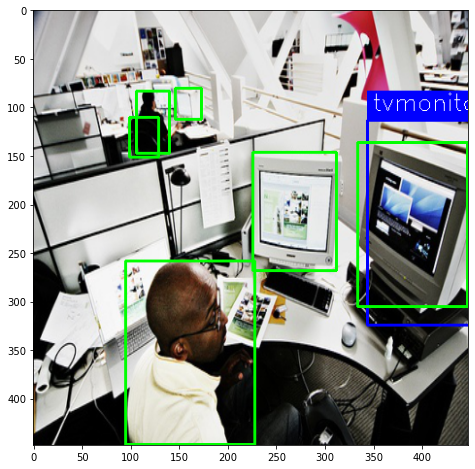

In [168]:
plt.figure(figsize=(8,8))
copy_img = tensor2np_uint8(testimg)
draw_pred(copy_img, bbox_result, best_index, class_show=True)
draw_label(copy_img,labels)
plt.imshow(copy_img)

In [163]:
conf_thres = 0.3 # the lower, the more boxes
nms_thres = 0.5 # the higher, the more boxes

In [164]:
def lots_of_prediction(label_index: list):
    for i in label_index:
        testimg, labels = trainset[i]
        testimgpred = model_predict(testimg)
        bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)    
        best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)
        
        plt.figure(figsize=(12,12))
        
        plt.subplot((131))
        copy_img = tensor2np_uint8(testimg)
        plt.imshow(copy_img)
        
        plt.subplot((132))
        copy_img = tensor2np_uint8(testimg)
        draw_label(copy_img, labels) 
        plt.imshow(copy_img)
        
        plt.subplot((133))
        copy_img = tensor2np_uint8(testimg)
        draw_pred(copy_img, bbox_result, best_index, class_show=True)
        plt.imshow(copy_img)

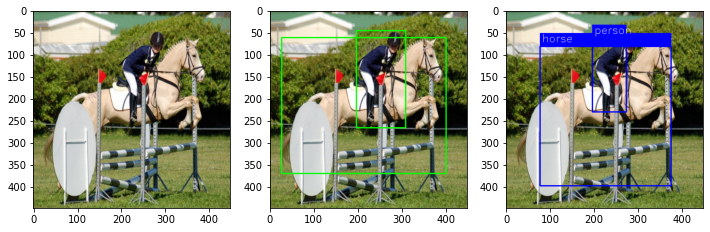

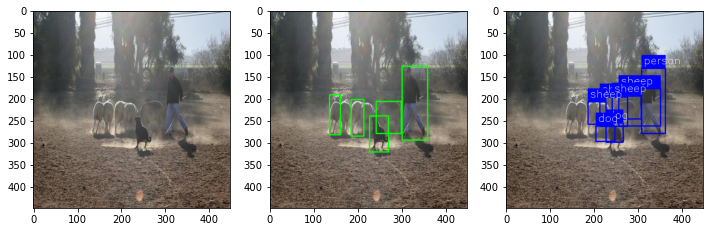

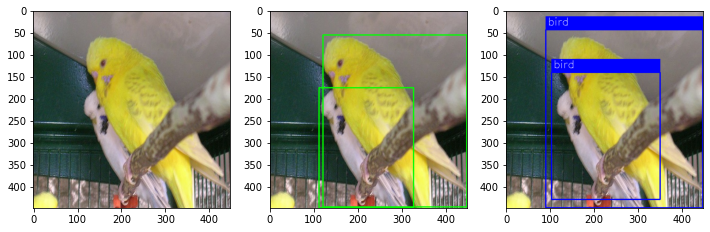

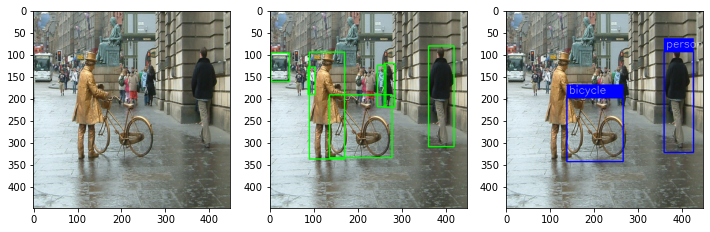

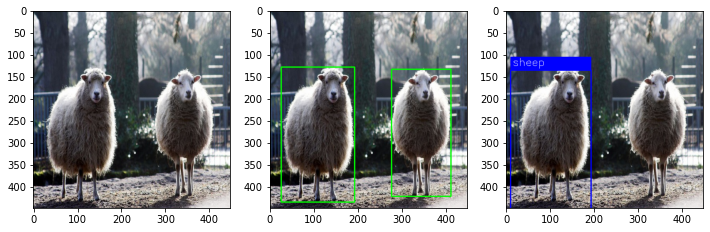

In [167]:
lots_of_prediction([100,102,41,55,67])

In [120]:
def lots_of_prediction_and_lots_of_model(label_index: list, model_list: list):
    
    num_col = 2+len(model_list)
    
    for i in label_index:
        testimg, labels = trainset[i]

        plt.figure(figsize=(30,30))

        plt.subplot(1,num_col,1)
        plt.title('original')
        copy_img = tensor2np_uint8(testimg)
        plt.imshow(copy_img)

        plt.subplot(1,num_col,2)
        plt.title('ground truth')
        copy_img = tensor2np_uint8(testimg)
        draw_label(copy_img, labels) 
        plt.imshow(copy_img)

        for mi, m in enumerate(model_list):
            model.load_state_dict(torch.load(m))

            testimgpred = model_predict(testimg)
            bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)    
            best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)

            plt.subplot(1,num_col,mi+3)
            plt.title(m)
            copy_img = tensor2np_uint8(testimg)
            draw_pred(copy_img, bbox_result, best_index, class_show=True)
            plt.imshow(copy_img)


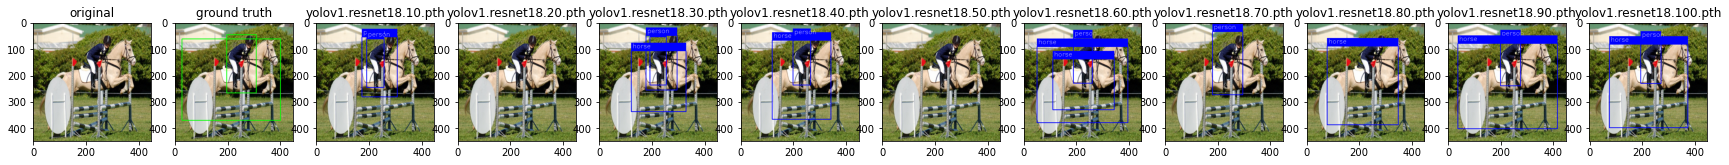

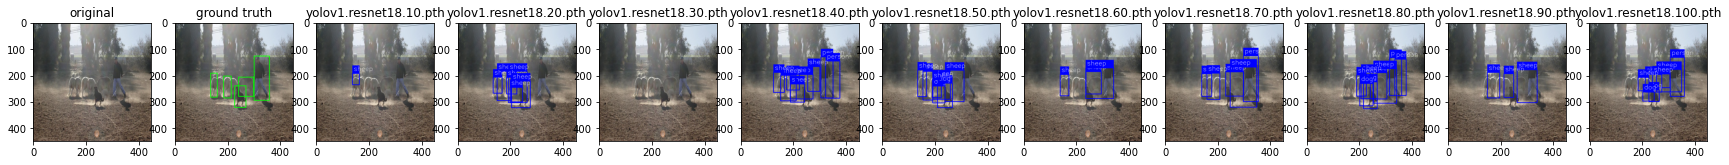

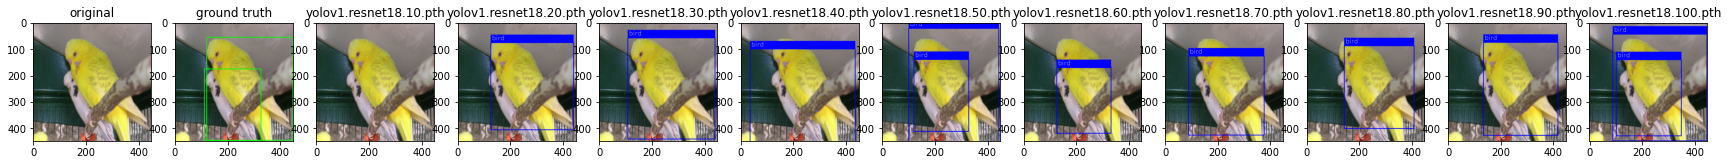

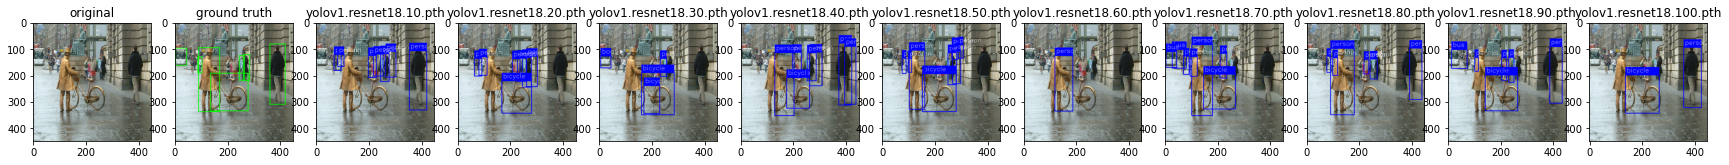

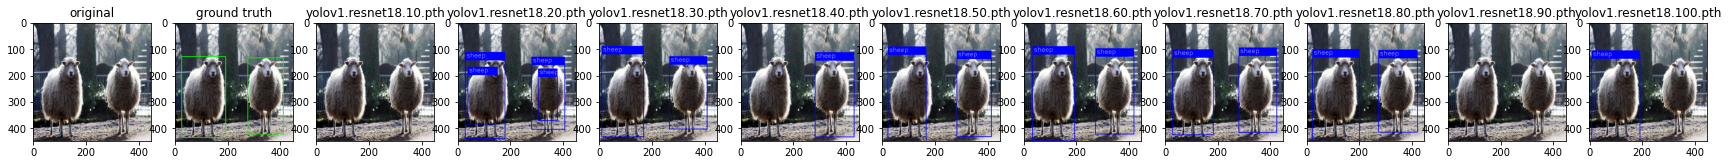

In [121]:
lots_of_prediction_and_lots_of_model([100,102,41,55,67],[f'yolov1.resnet18.{(i+1)*10}.pth' for i in range(10)])

# evaluation

In [60]:
testimg, labels = trainset[110]

a = time.time()
testimgpred = model_predict(testimg)
b = time.time()
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)
c = time.time()
best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)
d = time.time()

print('inference time: ', b-a)
print('decode time: ', c-b)
print('nms time: ', d-c)

inference time:  0.023969650268554688
decode time:  0.0
nms time:  0.002003192901611328


In [ ]:
# if coco, then evalute with pycocotools to less coding

In [63]:
def map_table(prediction: torch.Tensor, groundtruth: torch.Tensor, in_format: str = 'xywh') -> torch.Tensor:
    """produce iou and prob and gt num"""
    
    assert prediction.dim() == 2, 'the pred should be [N,4]'
    assert groundtruth.dim() == 2, 'the gt should be [M,4]'
    
    assert prediction.shape[1] == 5, 'coord 4 and prob 1'
    assert groundtruth.shape[1] == 4, 'coord 4'
    
    score = prediction[:,4] # ?
    score, csort = score.sort()
    
    if in_format == 'xywh':
        prediction = torchvision.ops.box_convert(prediction[:,:4],'xywh','xyxy')
        groundtruth = torchvision.ops.box_convert(groundtruth,'xywh','xyxy')
        
     
    # if many prediction overlapped with a ground truth, then only one prediction left
    # if many groundtruth overlapped with a prediction, then the prediction has the topest iou    
    
    ious = torchvision.ops.box_iou(prediction, groundtruth)
    iou_list, iou_index = ious.max(dim=1)
        
#     best_index = []
#     remove_index = []
#     for i in iou_index:
#         if i
    # later remove same gt bbox
    
    return iou_list, score, groundtruth.size(0) # ? # ? # int

In [64]:
def mean_average_precision(table: List[tuple], iou_thres: float = 0.5) -> Tuple[List[float], List[float], float]:
    """for single class not the whole dataset"""
        
    total_gt_num = sum(gt_num for _, _, gt_num in table)
    
    ious = torch.cat([iou for iou, _, _ in table if iou is not None],0)
        
    prob = torch.cat([prob for _, prob, _ in table if prob is not None],0)  
    
    _, prob_index = prob.sort()
    
    p = ious[prob_index]
    
    tp = p.gt(iou_thres).cumsum(0)
    
    precision = tp/torch.arange(1, tp.size(0)+1)
    recall = tp/total_gt_num
        
    auc = torch.trapz(precision,recall).item()
    
    return precision, recall, auc
    

In [123]:
def evaluate():
    
    MAP = {c: 0 for c in voc_classes}
    MAP_TABLE = {c: [] for c in voc_classes}
    
    # go through the dataset, not wise for big dataset
    for img, label in tqdm(testloader):
        
        img = img.to(device)
        
        with torch.no_grad():
            model.eval()
            output = model(img).detach().cpu()
            img = img.detach().cpu()
        
        # recover gt coord in xywh
        label[:,3:5] = label[:,3:5]*IMAGE_SIZE # return w,h
        grid_x, grid_y = generate_grid((7,7))
        label[:,1] = label[:,1]*IMAGE_SIZE+grid_x*64-label[:,3]/2 # return x1
        label[:,2] = label[:,2]*IMAGE_SIZE+grid_y*64-label[:,4]/2 # return y1
        
        batch_decoded_output = yolov1_decode(output, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1) # B, 98, 25
        for i in range(img.size(0)):
            batch_label = label[i] # 25, 7, 7
            batch_label = batch_label.view(25,-1).transpose(0,1) # 49, 25
            batch_label = batch_label[batch_label[:,0]==1] # ?, 25
            
            best_index = nms(batch_decoded_output[i,:,:4],batch_decoded_output[i,:,4], nms_thres, conf_thres)
            
            # if detection
            if len(best_index) != 0: 
                decoded_output = batch_decoded_output[i,best_index] # ?,25
                cls_index = decoded_output[:,5:].argmax(dim=1)
                decoded_output[:,4] = decoded_output[:,4]*decoded_output[:,5:].max(dim=1)[0]
                
                for c in range(len(voc_classes)):
                    
                    if not cls_index.eq(c).any(): continue
                    
                    tmp_label = batch_label[batch_label[:,5+c]==1,1:5]
                    
                    if tmp_label.size(0) == 0:
                        tmp_table = (torch.zeros(cls_index.eq(c).sum()), decoded_output[cls_index.eq(c),4], 0)
                    else:
                        tmp_table = map_table(decoded_output[cls_index.eq(c),:5], tmp_label)
                                        
                    MAP_TABLE[voc_classes[c]].append(tmp_table) # tuple
            else:
                for c in range(len(voc_classes)):
                    tmp_label = batch_label[:,5+c].sum().item()
                    if tmp_label:
                        tmp_table = (None, None, tmp_label)
                        MAP_TABLE[voc_classes[c]].append(tmp_table) # tuple
                
                
    
    # calculate pr curve and auc
    for c in voc_classes:
        if MAP_TABLE[c]:
            MAP[c] = mean_average_precision(MAP_TABLE[c])
           
    return MAP

In [124]:
conf_thres = 0.3 # the lower, the more boxes
nms_thres = 0.5 # the higher, the more boxes

In [66]:
map_score = evaluate()

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [01:09<00:00,  1.14it/s]


In [67]:
eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])

In [68]:
eval_table.loc['AP@0.5']

aeroplane      0.172346
bicycle         0.13133
bird           0.052561
boat           0.037528
bottle          0.00798
bus            0.063462
car             0.06423
cat             0.13065
chair          0.040679
cow            0.044283
diningtable    0.194742
dog            0.115854
horse          0.097703
motorbike      0.096983
person          0.14863
pottedplant    0.032827
sheep          0.035995
sofa           0.132177
train          0.201814
tvmonitor      0.031859
Name: AP@0.5, dtype: object

In [69]:
# mAP from raw PR curve
eval_table.loc['AP@0.5'].mean()

0.09168177652172745

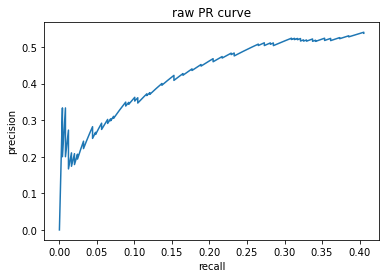

In [70]:
# aeroplane
plt.title('raw PR curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(eval_table['aeroplane']['recall'], eval_table['aeroplane']['precision'])

# Interpolated PR curve

In [71]:
# 11-point
interpolated_precision = []
for i in np.arange(0 ,1.1,0.1):
    p = eval_table['aeroplane']['precision'][eval_table['aeroplane']['recall'].gt(i)]
    if p.size(0) != 0: 
        interpolated_precision.append(p.max())
    else:
        interpolated_precision.append(0)

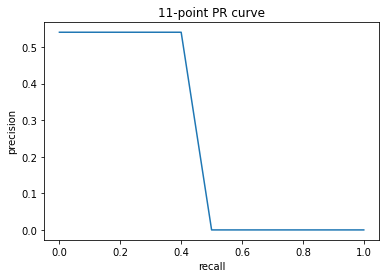

In [72]:
plt.title('11-point PR curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(np.arange(0 ,1.1,0.1),interpolated_precision)

In [73]:
def eleven_point_pr_curve(p:torch.Tensor, r:torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor]:
    interpolated_precision = []
    recall = np.arange(0 ,1.1,0.1)
    for i in recall:
        tmp_p = p[r.gt(i)]
        if tmp_p.size(0) != 0: 
            interpolated_precision.append(tmp_p.max())
        else:
            interpolated_precision.append(0)
        
    return torch.Tensor(interpolated_precision), torch.from_numpy(recall)

In [74]:
mAP = {c: 0 for c in voc_classes}
for c in voc_classes:
    p, r = eleven_point_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
    auc = torch.trapz(p,r).item()
    mAP[c] = auc

In [75]:
pd.DataFrame(mAP,index=['official AP@0.5'])

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
official AP@0.5,0.243048,0.19734,0.057778,0.080645,0.011973,0.099432,0.086683,0.153879,0.041651,0.087634,0.257143,0.153846,0.160887,0.125095,0.185507,0.05,0.036441,0.1925,0.23125,0.043614


In [76]:
# mAP from PR curve
np.array([mAP[c] for c in mAP]).mean()

0.12481737036257982

In [132]:
pd.concat([eval_table,pd.DataFrame(mAP,index=['official AP@0.5'])]).loc[['AP@0.5','official AP@0.5']]

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
AP@0.5,0.172346,0.13133,0.052561,0.037528,0.00798,0.063462,0.06423,0.13065,0.040679,0.044283,0.194742,0.115854,0.097703,0.096983,0.14863,0.032827,0.035995,0.132177,0.201814,0.031859
official AP@0.5,0.243048,0.19734,0.057778,0.080645,0.011973,0.099432,0.086683,0.153879,0.041651,0.087634,0.257143,0.153846,0.160887,0.125095,0.185507,0.05,0.036441,0.1925,0.23125,0.043614


# all epoch evaluation

In [130]:
result = {}
for m in [f'yolov1.resnet18.{(i+1)*10}.pth' for i in range(10)]:
    model.load_state_dict(torch.load(m))
    print(m)
    map_score = evaluate()
    eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
    mAP = {c: 0 for c in voc_classes}
    for c in voc_classes:
        p, r = eleven_point_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
        auc = torch.trapz(p,r).item()
        mAP[c] = auc
    result[m] = mAP

  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.10.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.20.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.30.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.40.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.50.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.60.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.70.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.80.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.90.pth


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

yolov1.resnet18.100.pth


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.45it/s]


In [137]:
cmap = [list(r.values())+[np.mean(list(r.values()))] for m,r in result.items()]
result_table = pd.DataFrame(cmap,columns=voc_classes+['all'],index=result.keys())
result_table

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,all
yolov1.resnet18.10.pth,0.190642,0.268038,0.050901,0.017035,0.007143,0.316721,0.133571,0.223272,0.061398,0.037812,...,0.202424,0.237760,0.300202,0.202678,0.011290,0.074768,0.267391,0.256840,0.085938,0.167746
yolov1.resnet18.20.pth,0.117067,0.269497,0.066471,0.015196,0.023214,0.185520,0.097474,0.374855,0.038747,0.071146,...,0.232380,0.254680,0.325278,0.222463,0.035953,0.038602,0.264118,0.205247,0.218203,0.172709
yolov1.resnet18.30.pth,0.148365,0.203060,0.076614,0.015788,0.025735,0.110217,0.130141,0.403323,0.061509,0.093874,...,0.268667,0.320716,0.205679,0.204735,0.046997,0.055645,0.204513,0.245296,0.180796,0.162864
yolov1.resnet18.40.pth,0.232967,0.219597,0.084834,0.026059,0.014851,0.164088,0.145978,0.349254,0.054560,0.198018,...,0.258025,0.276222,0.299265,0.215201,0.055618,0.072214,0.257373,0.249129,0.128788,0.178609
yolov1.resnet18.50.pth,0.172277,0.126633,0.083611,0.058016,0.018583,0.140667,0.152496,0.278901,0.035589,0.112609,...,0.200736,0.205220,0.246729,0.165778,0.030815,0.085890,0.074534,0.217819,0.096288,0.140660
yolov1.resnet18.60.pth,0.166667,0.155337,0.081983,0.012459,0.018419,0.160811,0.130952,0.273761,0.021840,0.106808,...,0.166905,0.320603,0.243243,0.176766,0.029167,0.113874,0.117297,0.316667,0.101402,0.141042
yolov1.resnet18.70.pth,0.236433,0.123348,0.068000,0.051749,0.060559,0.096675,0.122559,0.234146,0.040789,0.093680,...,0.126949,0.268357,0.203906,0.144372,0.050488,0.129113,0.159600,0.185192,0.254198,0.144030
yolov1.resnet18.80.pth,0.191081,0.109244,0.091797,0.035122,0.019760,0.082707,0.120362,0.178324,0.052181,0.030745,...,0.189457,0.192636,0.218280,0.121726,0.041436,0.107500,0.151277,0.155155,0.053459,0.113419
yolov1.resnet18.90.pth,0.145484,0.129545,0.048437,0.046528,0.023353,0.125152,0.093914,0.284783,0.028828,0.094072,...,0.164625,0.249363,0.189384,0.108549,0.050142,0.067986,0.159091,0.246078,0.184351,0.132296
yolov1.resnet18.100.pth,0.243048,0.197340,0.057778,0.080645,0.011973,0.099432,0.086683,0.153879,0.041651,0.087634,...,0.153846,0.160887,0.125095,0.185507,0.050000,0.036441,0.192500,0.231250,0.043614,0.124817


<AxesSubplot:>

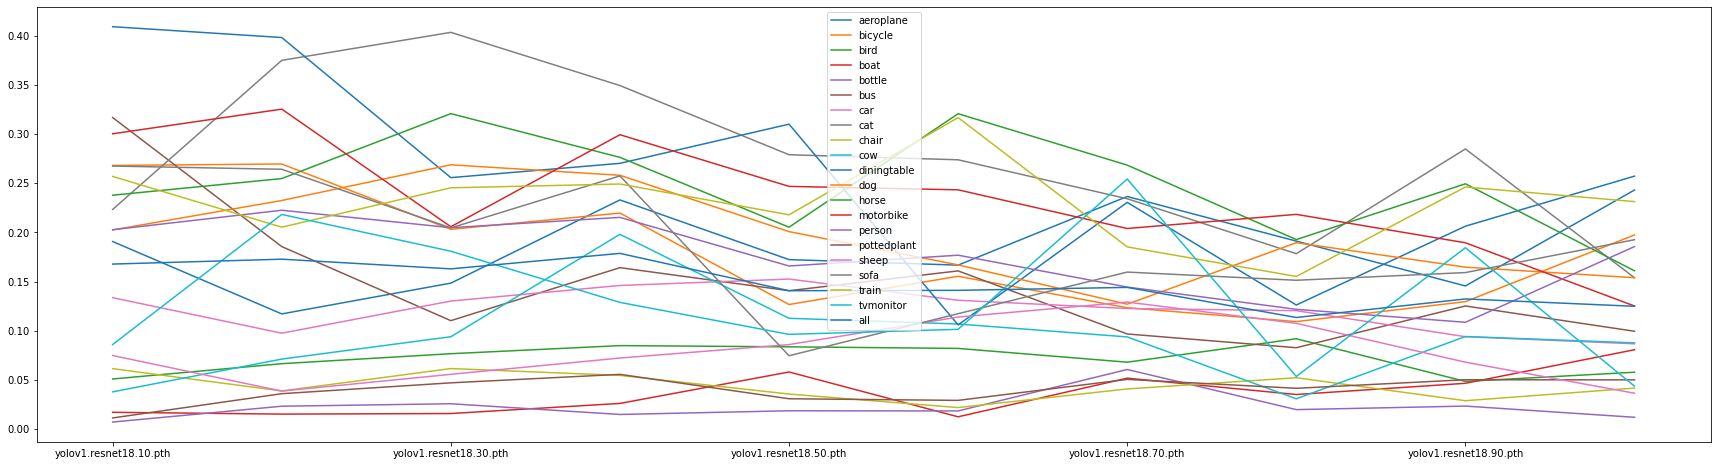

In [147]:
result_table.plot(figsize=(30,8))